In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
from scipy.sparse import csgraph
from sklearn.metrics.pairwise import pairwise_distances
from scipy.linalg import toeplitz
import magic

from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
def plotMat(mat, title):
    plt.imshow(mat, alpha=0.5)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)

    ax = plt.gca()

    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:0.1f}'.format(z), 
                ha='center', 
                va='center')

/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py:603: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(O, E)


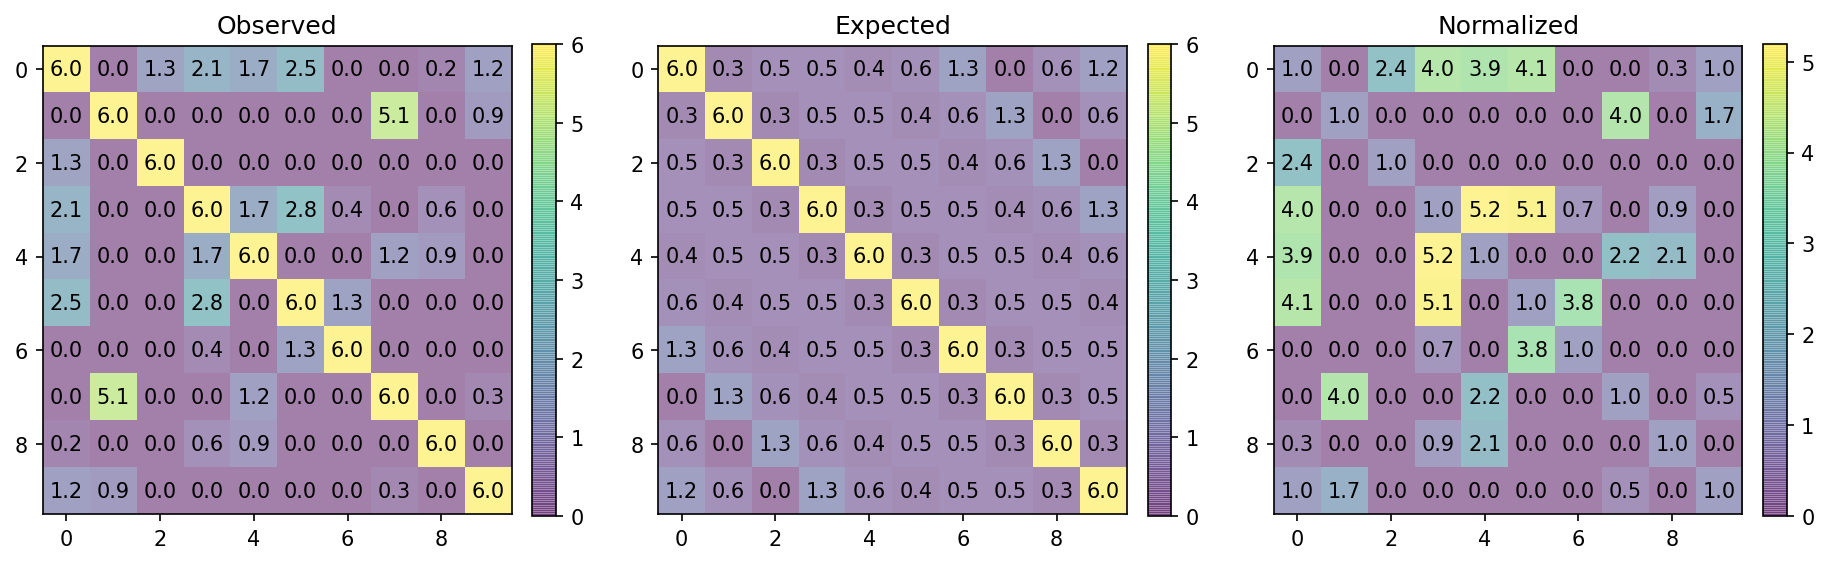

In [3]:
O = scipy.sparse.random(10, 10, density=0.18)
O = O.todense()
np.fill_diagonal(O, 1)
O = (O.T + O) * 3

E = pcu.getToeplitz(O)
A = pcu.normalizeToeplitz(O)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 15, 15


fig = plt.figure()

fig.add_subplot(131)
plotMat(O, 'Observed')

fig.add_subplot(132)
plotMat(E, 'Expected')

fig.add_subplot(133)
plotMat(A, 'Normalized')        

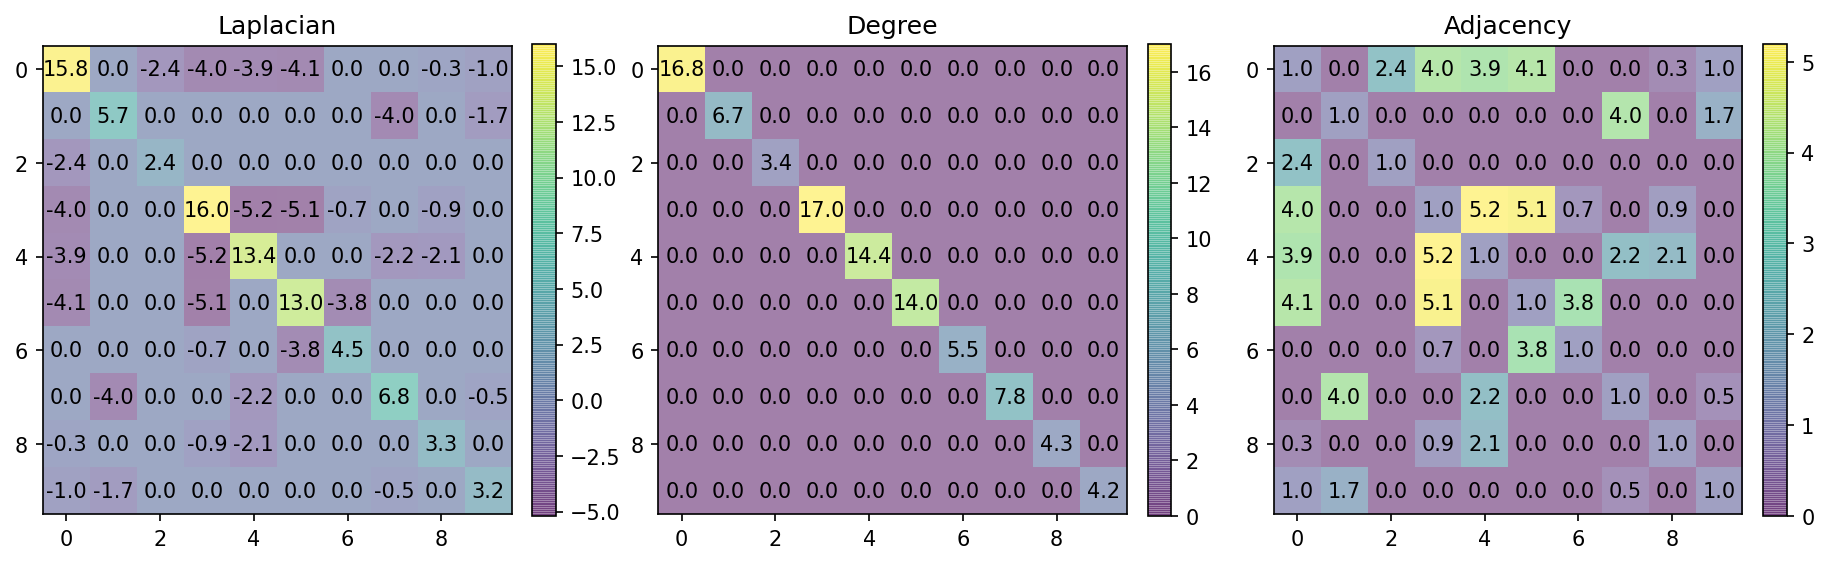

In [4]:
D = np.diag(A.sum(axis=0))
L = D - A

fig = plt.figure()

fig.add_subplot(131)
plotMat(L, 'Laplacian')

fig.add_subplot(132)
plotMat(D, 'Degree')

fig.add_subplot(133)
plotMat(A, 'Adjacency')  

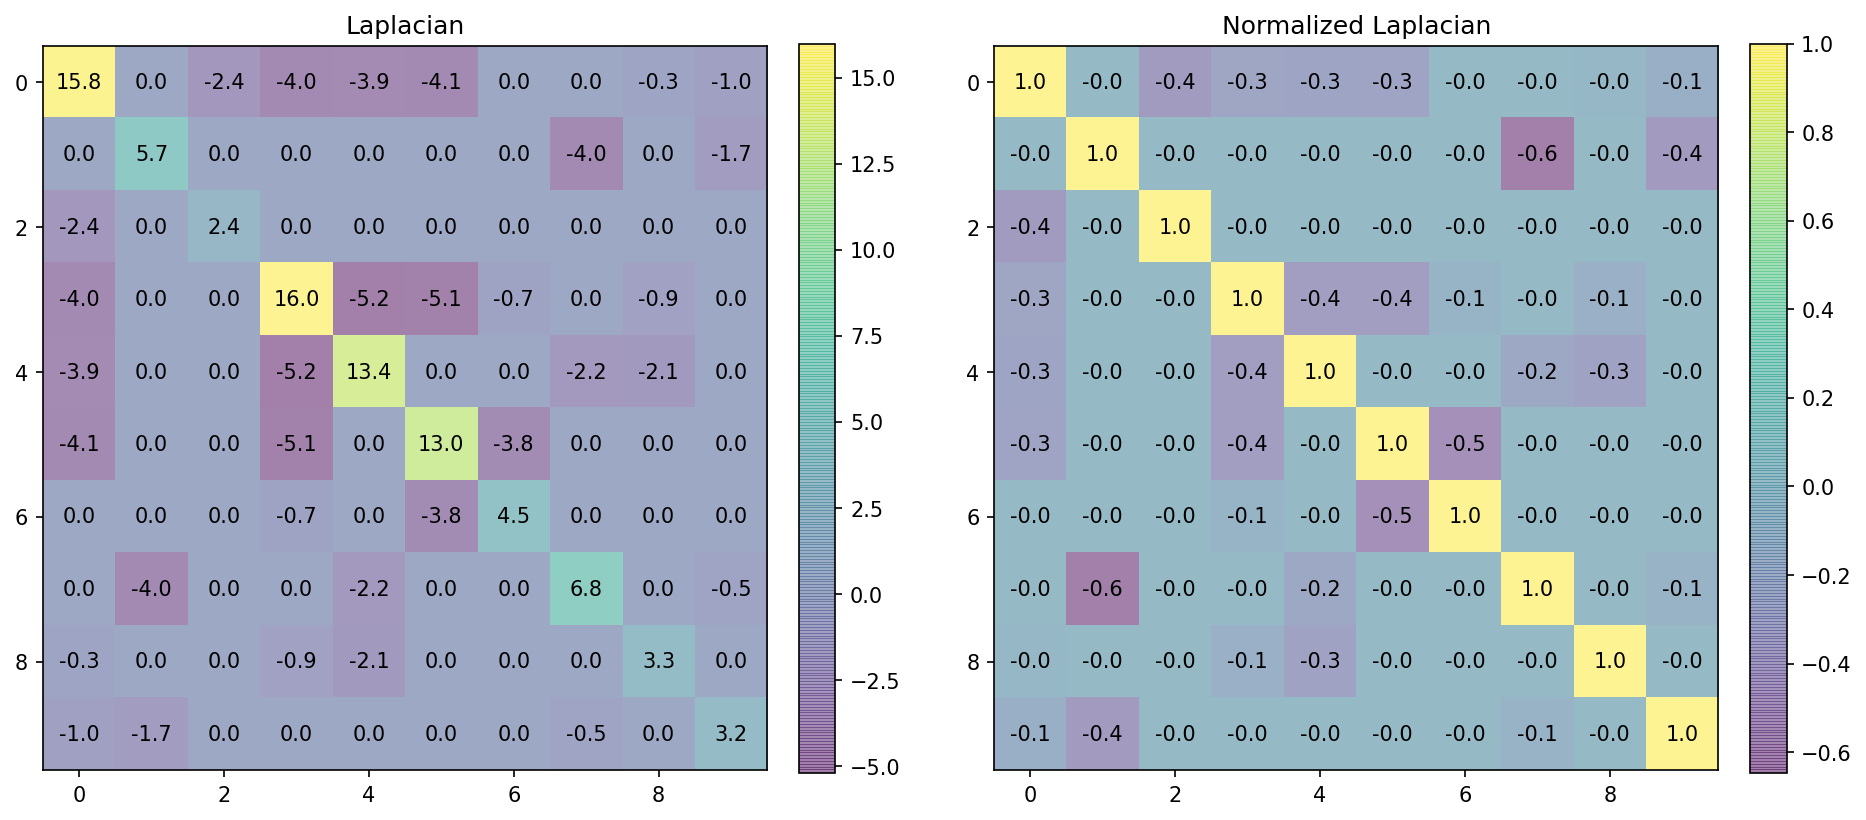

In [5]:
L = D - A
Lhat = csgraph.laplacian(A,  normed=True)

fig = plt.figure()

fig.add_subplot(121)
plotMat(L, 'Laplacian')

fig.add_subplot(122)
plotMat(Lhat, 'Normalized Laplacian')


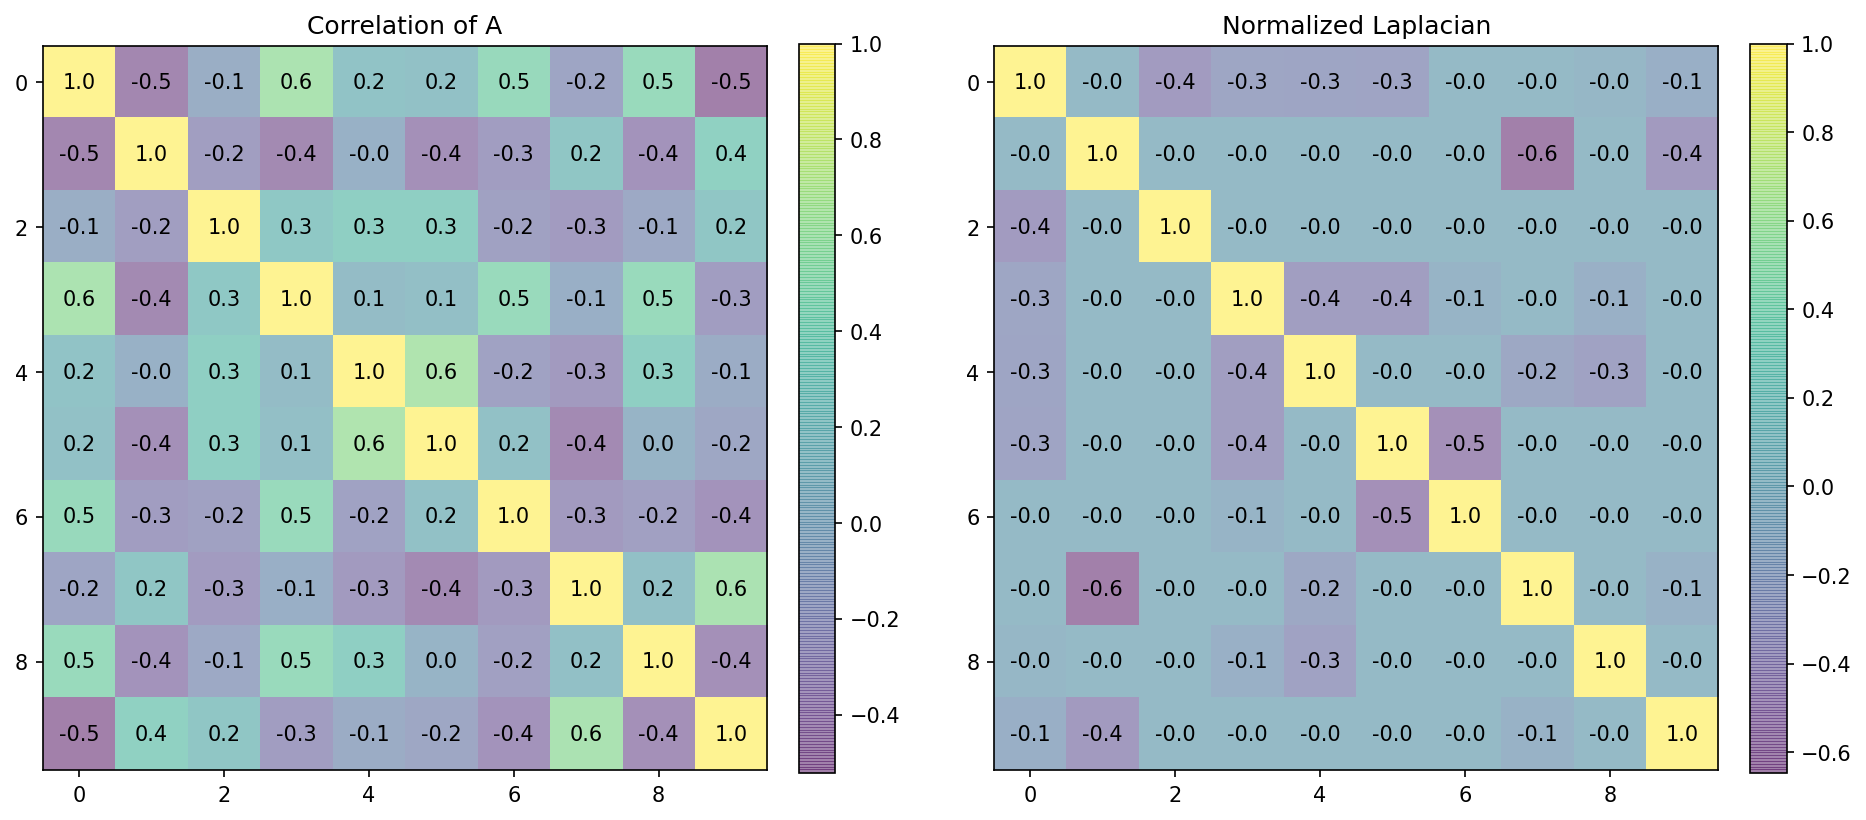

In [6]:
Acorr = np.corrcoef(A)
Lhat = csgraph.laplacian(A,  normed=True)

fig = plt.figure()

fig.add_subplot(121)
plotMat(Acorr, 'Correlation of A')

fig.add_subplot(122)
plotMat(Lhat, 'Normalized Laplacian')

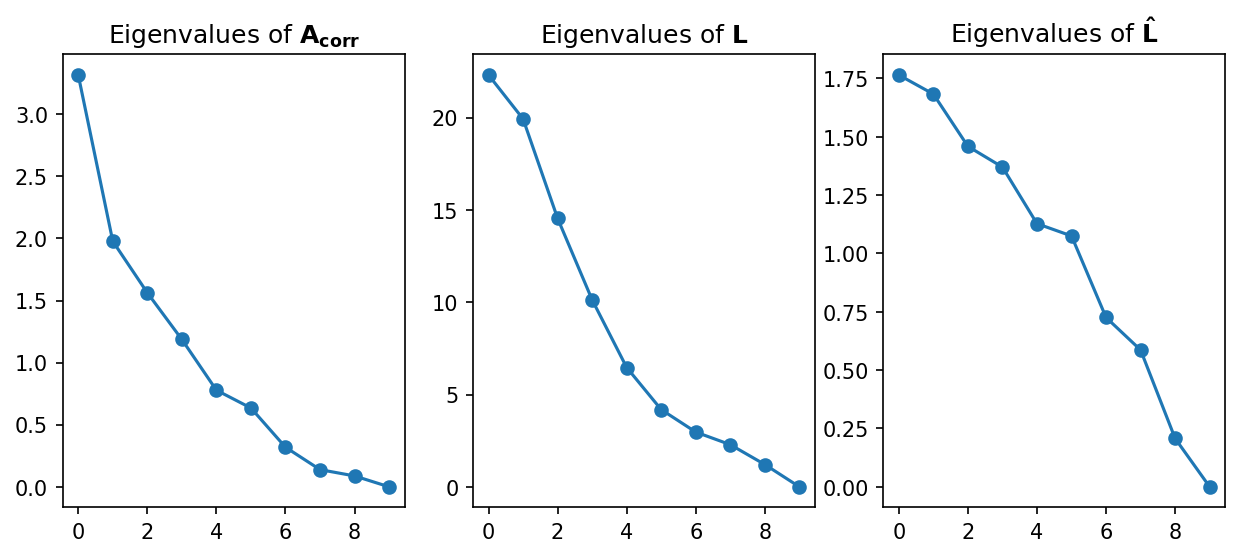

In [7]:
def plotEigs(mat, title):
    v, _ = np.linalg.eigh(mat)
    plt.plot(range(len(v)), 
             np.flip(v),
             marker='o')
    plt.title(title)


plt.rcParams['figure.figsize'] = 10, 4
fig = plt.figure()

fig.add_subplot(131)
plotEigs(Acorr, 'Eigenvalues of $\mathbf{A_{corr}}$')

fig.add_subplot(132)
plotEigs(L, 'Eigenvalues of $\mathbf{L}$')

fig.add_subplot(133)
plotEigs(Lhat, 'Eigenvalues of $\mathbf{\hat{L}}$')

In [8]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

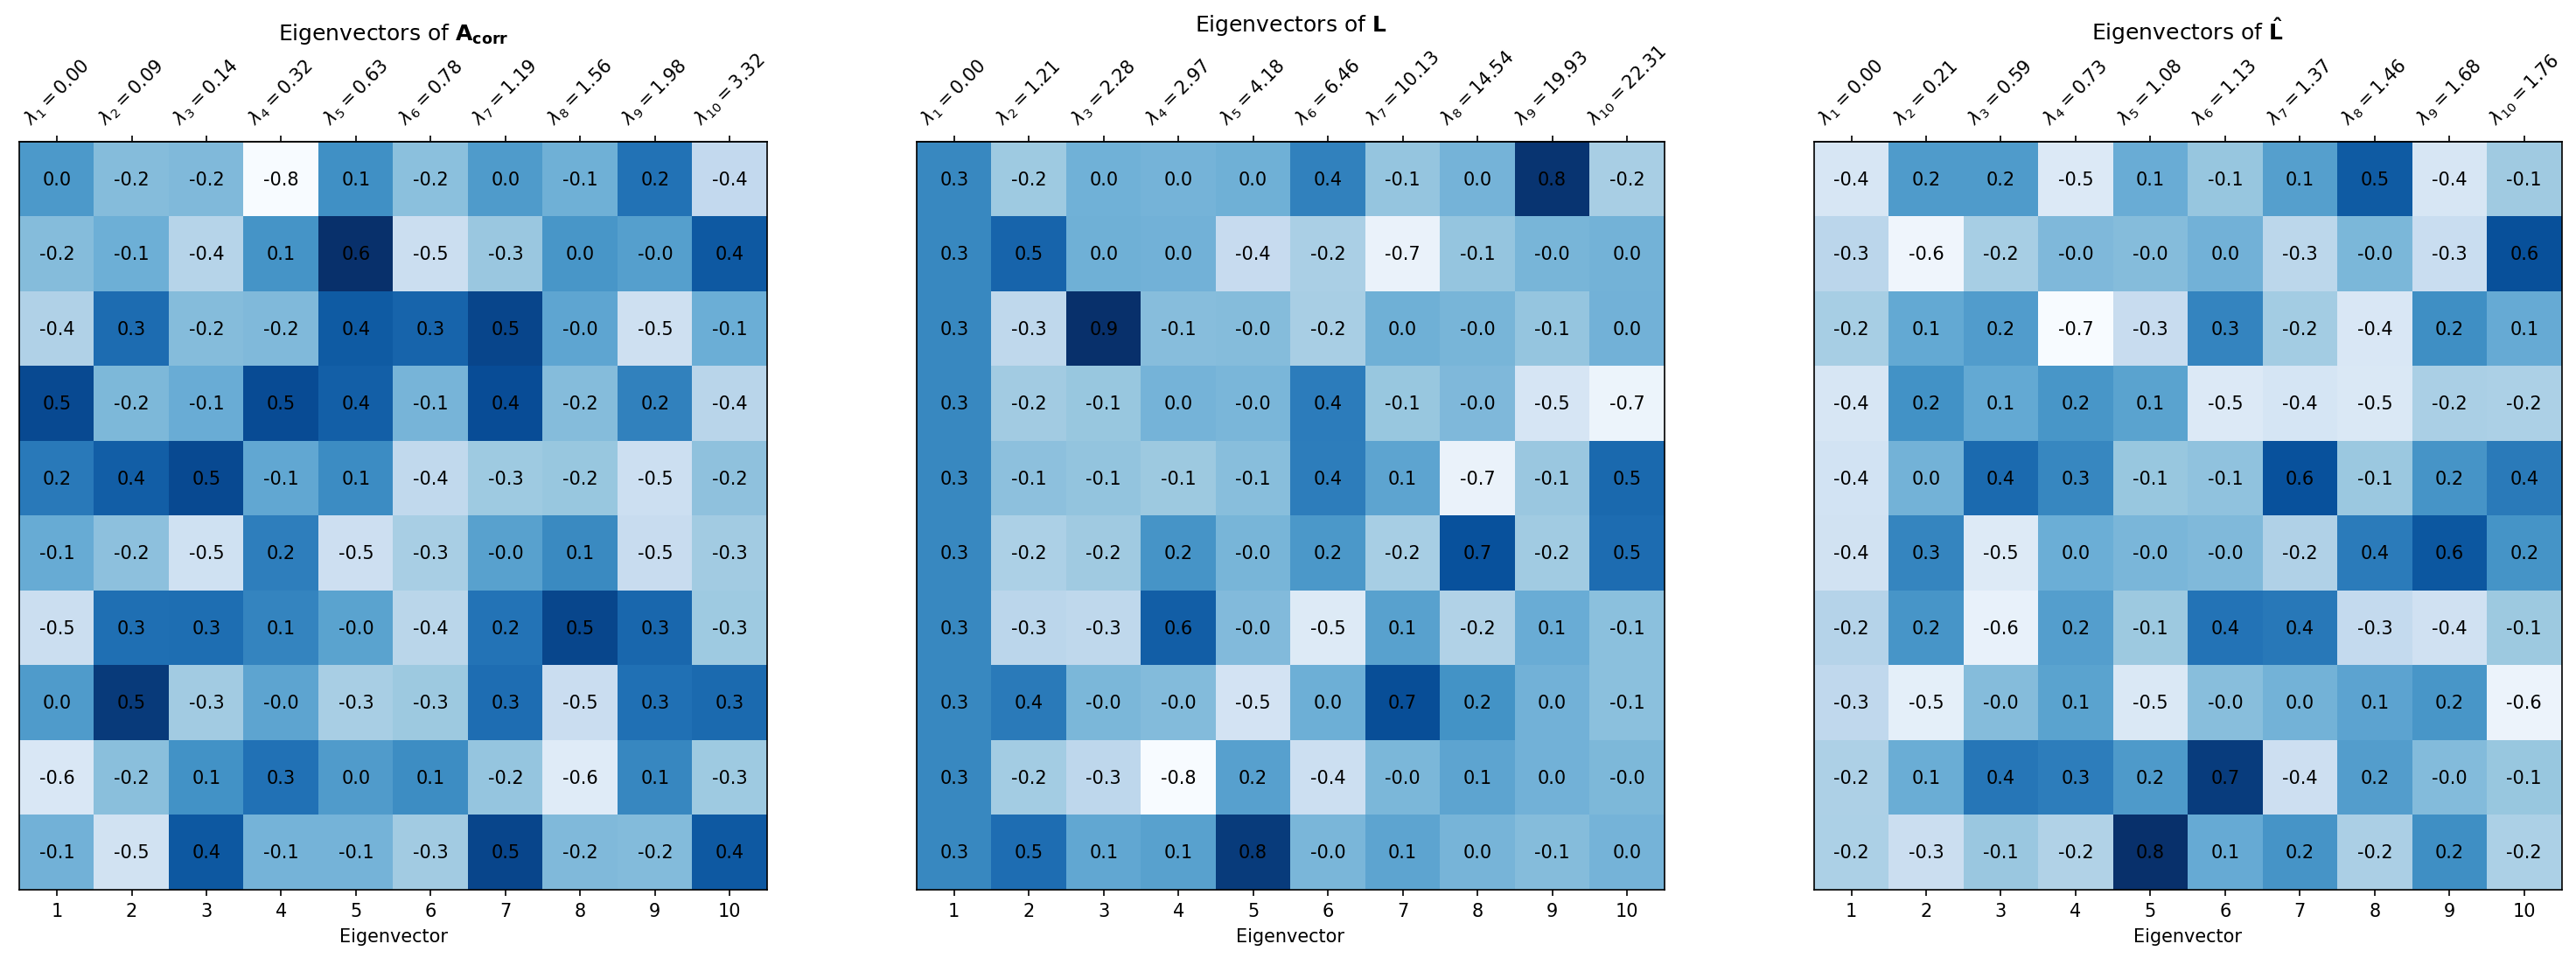

In [19]:
def plotEigvec(mat, title, ax, method='eig'):
    
    if method == 'eig':
        v, w = np.linalg.eigh(mat)
    elif method == 'svd':
        w, v, _ = np.linalg.svd(mat)
    else:
        raise ValueError('No such method')
    
    ax.imshow(w, cmap='Blues')
    for (i, j), z in np.ndenumerate(w):
        ax.text(j, i, '{:0.1f}'.format(z), 
                ha='center', 
                va='center')

    xticks = []
    xlabels = []
    for i in range(len(mat)):
        xticks.append(i)
        xlabels.append(f"{i+1}")
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Eigenvector')
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    newLabels = []
    for i in range(len(mat)):
        num = "{" + str(int(i+1)) + "}"
        eVal = v[i]
        label = f"$\lambda_{num} = {np.abs(eVal):.2f}$"
        newLabels.append(label)
    
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(newLabels, rotation=45)
    ax.set_title(title)
    
    
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 25, 25
fig, axs = plt.subplots(1, 3)

plotEigvec(Acorr, 'Eigenvectors of $\mathbf{A_{corr}}$', axs[0], method='eig')
plotEigvec(L, 'Eigenvectors of $\mathbf{L}$', axs[1], method='eig')
plotEigvec(Lhat, 'Eigenvectors of $\mathbf{\hat{L}}$', axs[2], method='eig')

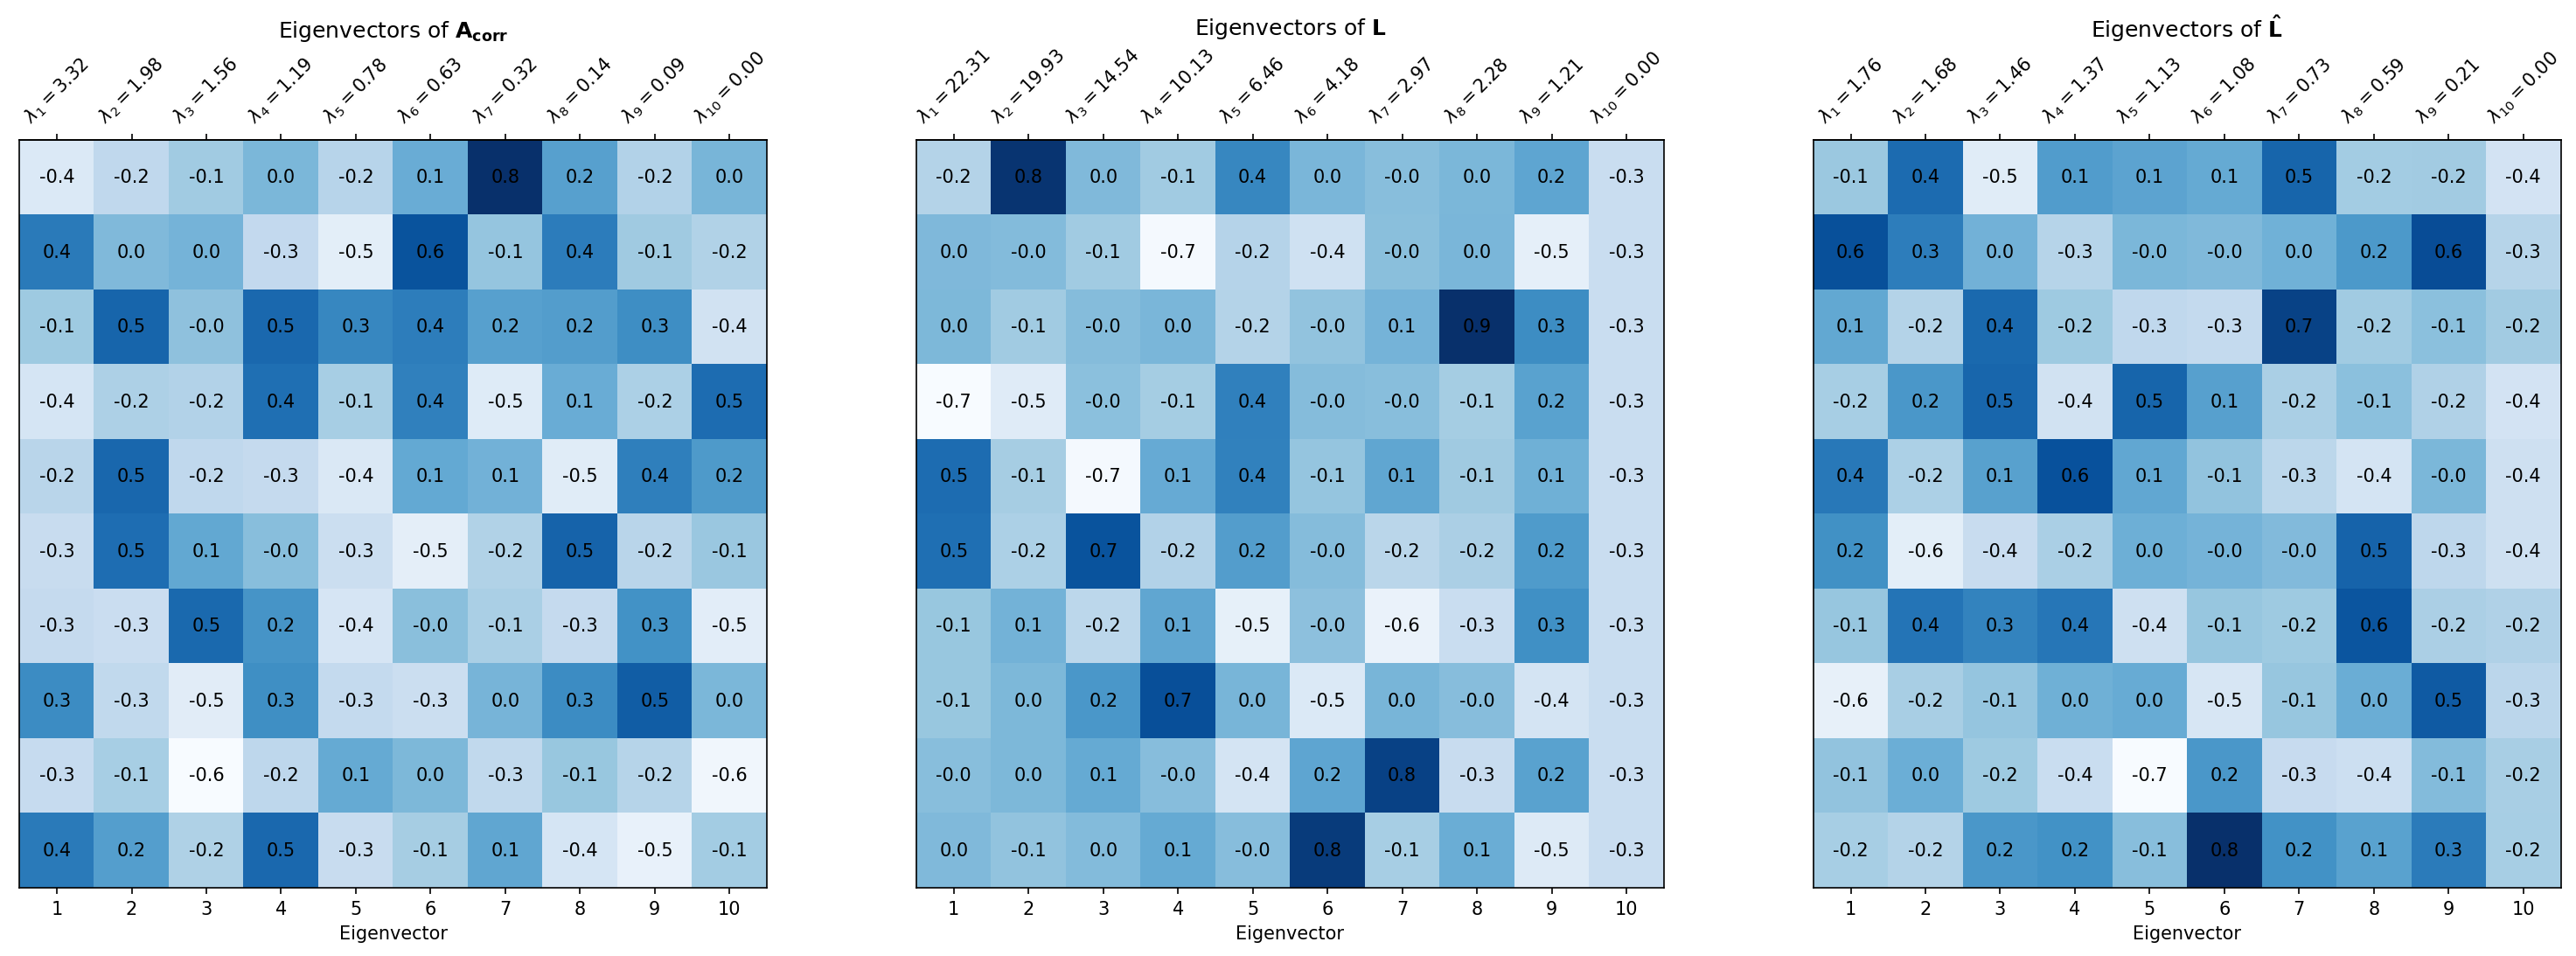

In [20]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 25, 25
fig, axs = plt.subplots(1, 3)

plotEigvec(Acorr, 'Eigenvectors of $\mathbf{A_{corr}}$', axs[0], method='svd')
plotEigvec(L, 'Eigenvectors of $\mathbf{L}$', axs[1], method='svd')
plotEigvec(Lhat, 'Eigenvectors of $\mathbf{\hat{L}}$', axs[2], method='svd')

In [57]:
def makeO(sparsity, n=10):
    O = scipy.sparse.random(n, n, density=sparsity)
    O = O.todense()
    np.fill_diagonal(O, 1)
    O = (O.T + O) 
    return O

newRows = []

nPoints = 200
n = 20

for sp in np.linspace(0.01, 0.99, nPoints):
    O = makeO(sp, n=n)
    A = pcu.normalizeToeplitz(O)
    
    Acorr = np.corrcoef(A)
    Lhat = csgraph.laplacian(A,  normed=True)
    
    v, w = np.linalg.eigh(Lhat)
    fiedlerVec = w[:, 1]
    
    row = {
        'sparsity' : sp,
        'n' : n,
        'fiedlerNumber' : v[1],
        'meanDegA' : np.mean(A.sum(axis=0)),
        'Amax' : A.max(),
        'Amin' : A.min(),
        '||Acorr - L||' : np.linalg.norm(Acorr - Lhat)
    }
    
    v, w = np.linalg.eigh(Acorr)
    principalComponents = np.flip(w)
    
    for i in range(len(w)):
        label = f"FVvPC{i+1}corr"
        corr, Pval = scipy.stats.pearsonr(fiedlerVec, principalComponents[:, i])
        row[label] = corr
        
        label = f"FVvPC{i+1}diff"
        row[label] = np.mean(principalComponents[:, i] - fiedlerVec)
        
        
        
        
    newRows.append(row)
    
    
df = pd.DataFrame(newRows)
df.head()

/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/pore_c_utils.py:603: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(O, E)


,sparsity,n,fiedlerNumber,meanDegA,Amax,Amin,||Acorr - L||,FVvPC1corr,FVvPC1diff,FVvPC2corr,...,FVvPC16corr,FVvPC16diff,FVvPC17corr,FVvPC17diff,FVvPC18corr,FVvPC18diff,FVvPC19corr,FVvPC19diff,FVvPC20corr,FVvPC20diff
0,0.010000,20,0.000000e+00,6.2,19.000000,0.0,4.828377,-0.052512,-0.044183,0.053167,...,2.748207e-16,-0.050000,1.846221e-16,-0.050000,5.234725e-17,-0.050000,7.286406e-18,-0.050000,-0.171832,-0.273387
1,0.014925,20,0.000000e+00,7.9,18.000000,0.0,4.783924,0.669083,-0.016706,0.171967,...,9.799566e-18,-0.050000,4.291991e-17,-0.050000,-1.339118e-01,-0.074994,-7.894150e-01,0.090889,-0.565666,-0.218081
2,0.019849,20,0.000000e+00,11.0,18.000000,0.0,4.862917,-0.053786,0.053406,0.218358,...,-5.270463e-01,0.070711,6.211980e-03,0.089622,2.372336e-02,-0.033195,-2.500243e-02,0.192731,0.026102,-0.075919
3,0.024774,20,-2.680346e-16,8.9,17.890049,0.0,5.580986,0.090041,-0.054965,0.180548,...,-6.092457e-02,0.151202,1.228232e-01,-0.008501,1.264690e-01,0.088309,-1.024402e-01,-0.072182,-0.196799,-0.066781
4,0.029698,20,-1.962845e-16,12.9,19.000000,0.0,5.847122,-0.033529,-0.067638,-0.305421,...,1.583302e-01,0.086527,-1.089486e-02,-0.076842,-9.490488e-02,-0.053521,6.307755e-01,0.074811,0.688647,-0.105199


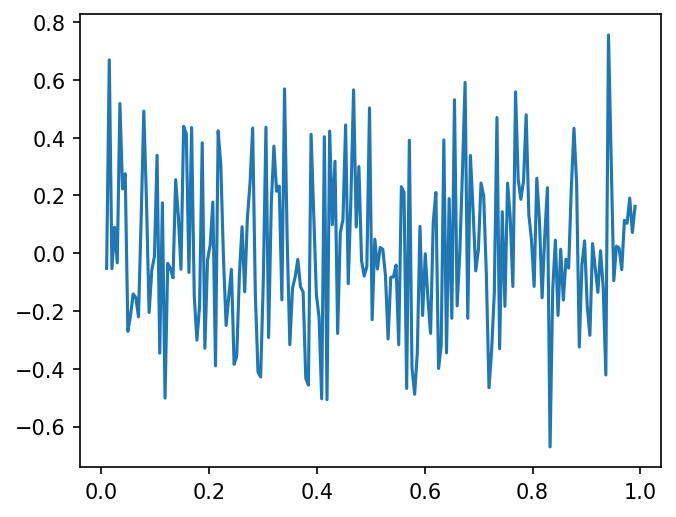

In [61]:
plt.rcParams['figure.figsize'] = 5, 4
plt.plot(df['sparsity'], df['FVvPC1corr'])